In [1]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', one_hot=True,validation_size=18000)
import matplotlib.pyplot as plt
import numpy as np
import random as ran
import tensorflow as tf

/home/kritz/anaconda3/envs/scripts/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [2]:
print(mnist.train.images.shape)

(42000, 784)


In [3]:
# To stop potential randomness
seed = 128
rng = np.random.RandomState(seed)

In [4]:
def param(layers,nhidden1,nhidden2 = 15):
    # Network Parameters
    n_hidden_1 = nhidden1# 1st layer number of neurons
    n_hidden_2 = nhidden2
    num_input = 784 # MNIST data input (img shape: 28*28)
    num_classes = 10 # MNIST total classes (0-9 digits)

    # tf Graph input
    X = tf.placeholder("float", [None, num_input])
    Y = tf.placeholder("float", [None, num_classes])

    if layers == 1:
        # Store layers weight & bias
        weights = {
            'h1': tf.Variable(tf.random_normal([num_input, n_hidden_1])),
            'out': tf.Variable(tf.random_normal([n_hidden_1, num_classes]))
        }
        biases = {
            'b1': tf.Variable(tf.random_normal([n_hidden_1])),
            'out': tf.Variable(tf.random_normal([num_classes]))
        }
    elif layers == 2:
        # Store layers weight & bias
        weights = {
            'h1': tf.Variable(tf.random_normal([num_input, n_hidden_1])),
            'h2': tf.Variable(tf.random_normal([n_hidden_1, n_hidden_2])),
            'out': tf.Variable(tf.random_normal([n_hidden_1, num_classes]))
        }
        biases = {
            'b1': tf.Variable(tf.random_normal([n_hidden_1])),
            'b2': tf.Variable(tf.random_normal([n_hidden_2])),
            'out': tf.Variable(tf.random_normal([num_classes]))
        }
    return(weights,biases,X,Y)

In [5]:
# Create model one layer
def neural_net1(x,weights,biases):
    # Hidden fully connected layer with neurons
    layer_1 = tf.add(tf.matmul(x, weights['h1']), biases['b1'])
    # Output fully connected layer with a neuron for each class
    out_layer = tf.matmul(layer_1, weights['out']) + biases['out']
    return out_layer

In [6]:
# Create model two layers
def neural_net2(x,weights,biases):
    # Hidden fully connected layer with 256 neurons
    layer_1 = tf.add(tf.matmul(x, weights['h1']), biases['b1'])
    # Hidden fully connected layer with 256 neurons
    layer_2 = tf.add(tf.matmul(layer_1, weights['h2']), biases['b2'])
    # Output fully connected layer with a neuron for each class
    out_layer = tf.matmul(layer_2, weights['out']) + biases['out']
    return out_layer

In [7]:
# Construct model
def model(layers,nhidden1,nhidden2=15):
    #Parameters
    learning_rate = 0.1
    num_steps = 500
    batch_size = 50
    
    weight,bias,X,Y = param(layers,nhidden1,nhidden2)
    if layers == 1:
        logits = neural_net1(X,weight,bias)
    elif layers == 2:
        logits = neural_net2(X,weight,bias)

    # Define loss and optimizer
    loss_op = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=Y))
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
    train_op = optimizer.minimize(loss_op)

    # Evaluate model (with test logits, for dropout to be disabled)
    correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(Y, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

    # Initialize the variables (i.e. assign their default value)
    init = tf.global_variables_initializer()

    # Start training
    with tf.Session() as sess:

        # Run the initializer
        sess.run(init)
        #Saving session
        saver = tf.train.Saver()
        lossTrain,accTrain,lossValid,accValid,ii = [],[],[],[],[]
        for i in range(0, num_steps):
            batch_x, batch_y = mnist.train.next_batch(batch_size)
            valid_x,valid_y = mnist.validation.next_batch(batch_size)
            # Run optimization op (backprop)
            model = sess.run(train_op, feed_dict={X: batch_x, Y: batch_y})
            # Calculate batch loss and accuracy
            lossT, accT = sess.run([loss_op, accuracy], feed_dict={X: batch_x,Y: batch_y})
            lossV, accV = sess.run([loss_op, accuracy], feed_dict={X: valid_x,Y: valid_y})
            lossTrain.append(lossT)
            accTrain.append(accT)
            lossValid.append(lossV)
            accValid.append(accV)
            ii.append(i)
            saver.save(sess, r'./nnModel1',global_step = i+1)
        sess = tf.Session()
        new_saver = tf.train.import_meta_graph('nnModel1-500.meta')
        new_saver.restore(sess, tf.train.latest_checkpoint('./'))
        print("Testing Accuracy:", sess.run(accuracy, feed_dict={X: mnist.test.images,Y: mnist.test.labels}))
        return(ii,lossTrain,accTrain,lossValid,accValid)

In [8]:
def plot(ii,lossTrain,accTrain,lossValid,accValid):
    plt.plot(ii,lossTrain,color = 'b')
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.title("Epoch vs Loss(Train)")
    plt.show()

    plt.plot(ii,accTrain,color = 'b')
    plt.xlabel("Iterations")
    plt.ylabel("Accuracy")
    plt.title("Epoch vs Accuracy(Train)")
    plt.show()

    plt.plot(ii,lossValid,color = 'g')
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.title("Epoch vs Loss(Validation)")
    plt.show()

    plt.plot(ii,accValid,color = 'g')
    plt.xlabel("Iterations")
    plt.ylabel("Accuracy")
    plt.title("Epoch vs Accuracy(Validation)")
    plt.show()

    first,diffList = lossTrain[0],[]
    for each in lossTrain:
        diff = first-each
        first = each
        diffList.append(diff)

    plt.plot(ii,diffList,color = 'r')
    plt.xlabel("Iterations")
    plt.ylabel("Loss Difference")
    plt.title("Epoch vs Difference in Loss(Train)")
    plt.show()

INFO:tensorflow:Restoring parameters from ./nnModel1-500
Testing Accuracy: 0.8531


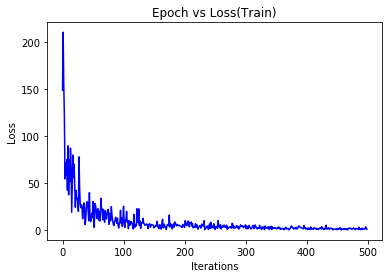

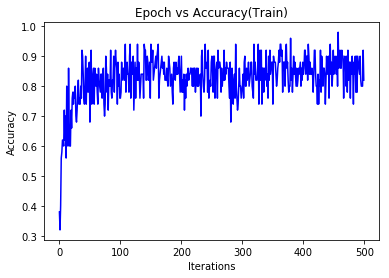

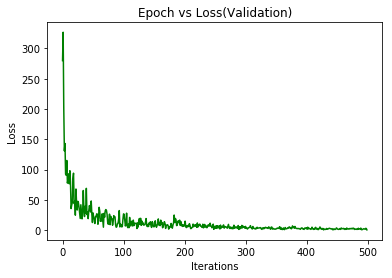

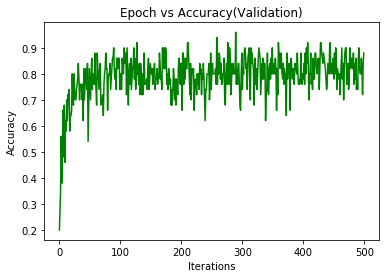

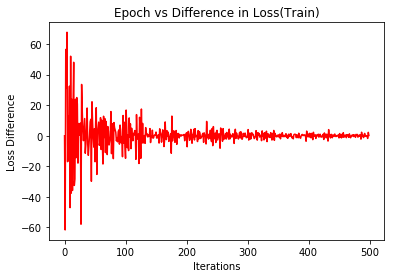

In [9]:
ii,lossTrain,accTrain,lossValid,accValid = model(2,25,25)
plot(ii,lossTrain,accTrain,lossValid,accValid)

In [ ]:
ii,lossTrain,accTrain,lossValid,accValid = model(2,15,15)
plot(ii,lossTrain,accTrain,lossValid,accValid)

In [ ]:
ii,lossTrain,accTrain,lossValid,accValid = model(1,15)
plot(ii,lossTrain,accTrain,lossValid,accValid)

In [ ]:
ii,lossTrain,accTrain,lossValid,accValid = model(1,25)
plot(ii,lossTrain,accTrain,lossValid,accValid)